In [60]:
# ruff: noqa
import pickle

from datasets import ClassLabel, Dataset, concatenate_datasets, load_dataset
from IPython.display import Markdown, display

from divide_and_conquer_sentiment import RobertaSentimentModel
from divide_and_conquer_sentiment.aggregation import MLP, MLPAggregator, SawonAggregator
from divide_and_conquer_sentiment.dataloaders import load_kaggle_dataset
from divide_and_conquer_sentiment.evaluation import (
    model_dataset_comparison,
    plot_metrics_per_token_count_bins,
    simple_classification_report,
)
from divide_and_conquer_sentiment.dacs_model import DACSModel
from divide_and_conquer_sentiment.sentiment_model import PolaritySentimentModel, RobertaSentimentModel
from divide_and_conquer_sentiment.subprediction import ABSASubpredictor, ChunkSubpredictor, Chunker

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
TRAIN_BATCH_SIZE = 256

In [4]:
!spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 6.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


# Read & prepare dataset


In [5]:
twitter_airlines_dataset = load_kaggle_dataset(
    "crowdflower/twitter-airline-sentiment",
    {"text": "text", "airline_sentiment": "label"},
    val_test_perc=(0.1, 0.2),
    seed=42,
)

Dataset URL: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment


/Users/pawel.marcinkowski/.pyenv/versions/venv-spacy/lib/python3.10/site-packages/kaggle/api_client.py:165: DeprecationWarning: HTTPResponse.getheaders() is deprecated and will be removed in urllib3 v2.1.0. Instead access HTTPResponse.headers directly.
  response_data.getheaders())


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/14640 [00:00<?, ? examples/s]

Map:   0%|          | 0/14640 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/14640 [00:00<?, ? examples/s]

In [6]:
amazon_headphones_dataset = load_kaggle_dataset(
    "mdwaquarazam/headphone-dataset-review-analysis",
    {"COMMENTS": "text", "RATINGS": "label"},
    val_test_perc=(0.1, 0.2),
    seed=42,
)

Dataset URL: https://www.kaggle.com/datasets/mdwaquarazam/headphone-dataset-review-analysis


/Users/pawel.marcinkowski/.pyenv/versions/venv-spacy/lib/python3.10/site-packages/kaggle/api_client.py:165: DeprecationWarning: HTTPResponse.getheaders() is deprecated and will be removed in urllib3 v2.1.0. Instead access HTTPResponse.headers directly.
  response_data.getheaders())


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1604 [00:00<?, ? examples/s]

Map:   0%|          | 0/1604 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1604 [00:00<?, ? examples/s]

In [7]:
SST_LABEL_MAP = {0: 0, 1: 0, 2: 1, 3: 2, 4: 2}


def map_sst_label(x):
    x["label"] = SST_LABEL_MAP[x["label"]]
    return x


sst_dataset = (
    load_dataset("SetFit/sst5")
    .remove_columns(["label_text"])
    .map(map_sst_label)
    .cast_column("label", ClassLabel(names=["negative", "neutral", "positive"]))
)

Repo card metadata block was not found. Setting CardData to empty.


In [10]:
train_dataset = concatenate_datasets(
    [twitter_airlines_dataset["train"], amazon_headphones_dataset["train"], sst_dataset["train"]]
)
val_dataset = concatenate_datasets(
    [twitter_airlines_dataset["val"], amazon_headphones_dataset["val"], sst_dataset["validation"]]
)

# ABSA

In [9]:
absa_subpredictor = ABSASubpredictor.from_pretrained(
    "tomaarsen/setfit-absa-bge-small-en-v1.5-restaurants-aspect",
    "tomaarsen/setfit-absa-bge-small-en-v1.5-restaurants-polarity",
    spacy_model="en_core_web_lg",
)
absa_polarity_model = absa_subpredictor.absa_model.polarity_model
absa_mlp = MLP(input_size=4, output_size=3, hidden_layer_sizes=(128, 64))
absa_mlp_aggregator = MLPAggregator(absa_mlp)

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: tomaarsen/setfit-absa-bge-small-en-v1.5-restaurants-aspect
/Users/pawel.marcinkowski/.pyenv/versions/venv-spacy/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: tomaarsen/setfit-absa-bge-small-en-v1.5-restaurants-polarity
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users

In [33]:
absa_train_subpreds = absa_subpredictor.predict(train_dataset["text"])
absa_val_subpreds = absa_subpredictor.predict(val_dataset["text"])

Batches:   0%|          | 0/2496 [00:00<?, ?it/s]

Batches:   0%|          | 0/349 [00:00<?, ?it/s]

In [34]:
train_absa_dataset = concatenate_datasets([train_dataset, Dataset.from_dict({"subpreds": absa_train_subpreds})], axis=1)
val_absa_dataset = concatenate_datasets([val_dataset, Dataset.from_dict({"subpreds": absa_val_subpreds})], axis=1)

Flattening the indices:   0%|          | 0/19914 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/2726 [00:00<?, ? examples/s]

In [35]:
with open("train_dataset_absa.pkl", "wb") as handle:
    pickle.dump(train_absa_dataset, handle)

with open("val_dataset_absa.pkl", "wb") as handle:
    pickle.dump(val_absa_dataset, handle)

In [36]:
with open("train_dataset_absa.pkl", "rb") as handle:
    train_absa_dataset = pickle.load(handle).with_format("torch")

with open("val_dataset_absa.pkl", "rb") as handle:
    val_absa_dataset = pickle.load(handle).with_format("torch")

## MLP

In [37]:
absa_mlp_aggregator.train(train_absa_dataset, val_absa_dataset)

/Users/pawel.marcinkowski/.pyenv/versions/venv-spacy/lib/python3.10/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | layers | ModuleList | 11.3 K | train
----------------------------------------------
11.3 K    Trainable params
0         Non-trainable params
11.3 K    Total params
0.045     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/pawel.marcinkowski/.pyenv/versions/venv-spacy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/pawel.marcinkowski/.pyenv/versions/venv-spacy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [38]:
with open("absa_mlp_aggregator.pkl", "wb") as handle:
    pickle.dump(absa_mlp_aggregator, handle)

In [39]:
with open("absa_mlp_aggregator.pkl", "rb") as handle:
    absa_mlp_aggregator = pickle.load(handle)

In [40]:
dacs_absa_mlp = DACSModel(absa_subpredictor, absa_mlp_aggregator)

In [41]:
twitter_test_absa_mlp_preds = dacs_absa_mlp.classify(twitter_airlines_dataset["test"]["text"])
amazon_test_absa_mlp_preds = dacs_absa_mlp.classify(amazon_headphones_dataset["test"]["text"])
sst_test_absa_mlp_preds = dacs_absa_mlp.classify(sst_dataset["test"]["text"])

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

Batches:   0%|          | 0/265 [00:00<?, ?it/s]

# Sentence

In [11]:
polarity_sentiment_model = PolaritySentimentModel(absa_polarity_model)
chunker = Chunker()
sentence_subpredictor = ChunkSubpredictor(chunker, polarity_sentiment_model)

In [12]:
sentence_train_subpreds = sentence_subpredictor.predict(train_dataset["text"])
sentence_val_subpreds = sentence_subpredictor.predict(val_dataset["text"])

/Users/pawel.marcinkowski/Repos/NLU/divide-and-conquer-sentiment/src/divide_and_conquer_sentiment/subprediction/sentence.py:51: UserWarning: For text: "", splitting into sentences failed. Returned list with 1 empty string
  warn(f'For text: "{text}", splitting into sentences failed. Returned list with 1 empty string')
/Users/pawel.marcinkowski/Repos/NLU/divide-and-conquer-sentiment/src/divide_and_conquer_sentiment/subprediction/sentence.py:51: UserWarning: For text: "", splitting into sentences failed. Returned list with 1 empty string
  warn(f'For text: "{text}", splitting into sentences failed. Returned list with 1 empty string')


In [13]:
train_sentence_dataset = concatenate_datasets(
    [train_dataset, Dataset.from_dict({"subpreds": sentence_train_subpreds})], axis=1
)
val_sentence_dataset = concatenate_datasets(
    [val_dataset, Dataset.from_dict({"subpreds": sentence_val_subpreds})], axis=1
)

Flattening the indices:   0%|          | 0/19914 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/19914 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/2726 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/2726 [00:00<?, ? examples/s]

In [14]:
with open("train_dataset_sentence.pkl", "wb") as handle:
    pickle.dump(train_sentence_dataset, handle)

with open("val_dataset_sentence.pkl", "wb") as handle:
    pickle.dump(val_sentence_dataset, handle)

In [15]:
with open("train_dataset_sentence.pkl", "rb") as handle:
    train_sentence_dataset = pickle.load(handle).with_format("torch")

with open("val_dataset_sentence.pkl", "rb") as handle:
    val_sentence_dataset = pickle.load(handle).with_format("torch")

In [16]:
train_defaults = polarity_sentiment_model.predict(train_dataset["text"])
val_defaults = polarity_sentiment_model.predict(val_dataset["text"])
twitter_test_defaults = polarity_sentiment_model.predict(twitter_airlines_dataset["test"]["text"])
amazon_test_defaults = polarity_sentiment_model.predict(amazon_headphones_dataset["test"]["text"])
sst_test_defaults = polarity_sentiment_model.predict(sst_dataset["test"]["text"])

## RoBERTa

In [17]:
from transformers import pipeline

In [18]:
roberta = pipeline("text-classification", model="j-hartmann/sentiment-roberta-large-english-3-classes", return_all_scores=True)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Some weights of the model checkpoint at j-hartmann/sentiment-roberta-large-english-3-classes were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model fr

In [74]:
roberta_sentiment_model = RobertaSentimentModel(roberta)

In [84]:
twitter_test_roberta_preds = roberta_sentiment_model.classify(twitter_airlines_dataset["test"]["text"])
amazon_test_roberta_preds = roberta_sentiment_model.classify(amazon_headphones_dataset["test"]["text"])
sst_test_roberta_preds = roberta_sentiment_model.classify(sst_dataset["test"]["text"])

## SAWON

In [26]:
sawon = SawonAggregator(0.9)
dacs_sawon = DACSModel(sentence_subpredictor, sawon)

In [27]:
sawon_train_preds = sawon.classify(sentence_train_subpreds, defaults=train_defaults)
sawon_val_preds = sawon.classify(sentence_val_subpreds, defaults=val_defaults)
twitter_test_sawon_preds = dacs_sawon.classify(twitter_airlines_dataset["test"]["text"], defaults=twitter_test_defaults)
amazon_test_sawon_preds = dacs_sawon.classify(amazon_headphones_dataset["test"]["text"], defaults=amazon_test_defaults)
sst_test_sawon_preds = dacs_sawon.classify(sst_dataset["test"]["text"], defaults=sst_test_defaults)

/Users/pawel.marcinkowski/Repos/NLU/divide-and-conquer-sentiment/src/divide_and_conquer_sentiment/subprediction/sentence.py:51: UserWarning: For text: "", splitting into sentences failed. Returned list with 1 empty string
  warn(f'For text: "{text}", splitting into sentences failed. Returned list with 1 empty string')


## RoBERTa SAWON

In [23]:
roberta_chunker = Chunker()
roberta_sawon = SawonAggregator(0.9)
sentence_roberta_subpredictor = ChunkSubpredictor(chunker, roberta_sentiment_model)
dacs_roberta_sawon = DACSModel(sentence_roberta_subpredictor, roberta_sawon)

In [24]:
twitter_test_roberta_sawon_preds = dacs_roberta_sawon.classify(twitter_airlines_dataset["test"]["text"], defaults=twitter_test_roberta_preds)
amazon_test_roberta_sawon_preds = dacs_roberta_sawon.classify(amazon_headphones_dataset["test"]["text"], defaults=amazon_test_roberta_preds)
sst_test_roberta_sawon_preds = dacs_roberta_sawon.classify(sst_dataset["test"]["text"], defaults=sst_test_roberta_preds)

/Users/pawel.marcinkowski/Repos/NLU/divide-and-conquer-sentiment/src/divide_and_conquer_sentiment/subprediction/sentence.py:51: UserWarning: For text: "", splitting into sentences failed. Returned list with 1 empty string
  warn(f'For text: "{text}", splitting into sentences failed. Returned list with 1 empty string')


## MLP

In [25]:
sentence_mlp = MLP(input_size=3, output_size=3, hidden_layer_sizes=(128, 64), lr=0.01)
sentence_mlp_aggregator = MLPAggregator(sentence_mlp)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [28]:
sentence_mlp_aggregator.train(train_sentence_dataset, val_sentence_dataset)

/Users/pawel.marcinkowski/.pyenv/versions/venv-spacy/lib/python3.10/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | layers | ModuleList | 10.6 K | train
----------------------------------------------
10.6 K    Trainable params
0         Non-trainable params
10.6 K    Total params
0.043     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/pawel.marcinkowski/.pyenv/versions/venv-spacy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/pawel.marcinkowski/.pyenv/versions/venv-spacy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [29]:
with open("sentence_mlp_aggregator.pkl", "wb") as handle:
    pickle.dump(sentence_mlp_aggregator, handle)

In [30]:
with open("sentence_mlp_aggregator.pkl", "rb") as handle:
    sentence_mlp_aggregator = pickle.load(handle)

In [31]:
dacs_sentences_mlp = DACSModel(sentence_subpredictor, sentence_mlp_aggregator)

In [32]:
twitter_test_sentence_mlp_preds = dacs_sentences_mlp.classify(
    twitter_airlines_dataset["test"]["text"], defaults=twitter_test_defaults
)
amazon_test_sentence_mlp_preds = dacs_sentences_mlp.classify(
    amazon_headphones_dataset["test"]["text"], defaults=amazon_test_defaults
)
sst_test_sentence_mlp_preds = dacs_sentences_mlp.classify(sst_dataset["test"]["text"], defaults=sst_test_defaults)

/Users/pawel.marcinkowski/Repos/NLU/divide-and-conquer-sentiment/src/divide_and_conquer_sentiment/subprediction/sentence.py:51: UserWarning: For text: "", splitting into sentences failed. Returned list with 1 empty string
  warn(f'For text: "{text}", splitting into sentences failed. Returned list with 1 empty string')


# Evaluate

In [42]:
twitter_test_absa_polarity_preds = absa_polarity_model.predict(twitter_airlines_dataset["test"]["text"])
amazon_test_absa_polarity_preds = absa_polarity_model.predict(amazon_headphones_dataset["test"]["text"])
sst_test_absa_polarity_preds = absa_polarity_model.predict(sst_dataset["test"]["text"])

Batches:   0%|          | 0/92 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/70 [00:00<?, ?it/s]

In [85]:
dataset_dict = {
    "twitter": twitter_airlines_dataset["test"],
    "amazon": amazon_headphones_dataset["test"],
    "sst": sst_dataset["test"],
}
preds_dict = {
    "twitter": {
        "polarity": twitter_test_absa_polarity_preds,
        "roberta": twitter_test_roberta_preds,
        "sawon": twitter_test_sawon_preds,
        "roberta_sawon": twitter_test_roberta_sawon_preds,
        "sentence_mlp": twitter_test_sentence_mlp_preds,
        "absa_mlp": twitter_test_absa_mlp_preds,
    },
    "amazon": {
        "polarity": amazon_test_absa_polarity_preds,
        "roberta": amazon_test_roberta_preds,
        "sawon": amazon_test_sawon_preds,
        "roberta_sawon": amazon_test_roberta_sawon_preds,
        "sentence_mlp": amazon_test_sentence_mlp_preds,
        "absa_mlp": amazon_test_absa_mlp_preds,
    },
    "sst": {
        "polarity": sst_test_absa_polarity_preds,
        "roberta": sst_test_roberta_preds,
        "sawon": sst_test_sawon_preds,
        "roberta_sawon": sst_test_roberta_sawon_preds,
        "sentence_mlp": sst_test_sentence_mlp_preds,
         "absa_mlp": sst_test_absa_mlp_preds,
    },
}

In [86]:
for dataset, preds in preds_dict.items():
    display(Markdown(f"### {dataset}"))
    for model, model_preds in preds.items():
        print(model)
        print(simple_classification_report(dataset_dict[dataset]["label"], model_preds))

### twitter

polarity
              precision    recall  f1-score   support

    negative       0.91      0.50      0.65      1893
     neutral       0.29      0.55      0.38       615
    positive       0.51      0.87      0.64       420

    accuracy                           0.56      2928
   macro avg       0.57      0.64      0.56      2928
weighted avg       0.72      0.56      0.59      2928

roberta
              precision    recall  f1-score   support

    negative       0.94      0.73      0.82      1893
     neutral       0.45      0.81      0.57       615
    positive       0.77      0.61      0.69       420

    accuracy                           0.73      2928
   macro avg       0.72      0.72      0.69      2928
weighted avg       0.81      0.73      0.75      2928

sawon
              precision    recall  f1-score   support

    negative       0.92      0.46      0.62      1893
     neutral       0.29      0.42      0.34       615
    positive       0.36      0.95      0.53       42

### amazon

polarity
              precision    recall  f1-score   support

    negative       0.81      0.82      0.81       112
     neutral       0.11      0.04      0.05        28
    positive       0.86      0.94      0.90       181

    accuracy                           0.82       321
   macro avg       0.59      0.60      0.59       321
weighted avg       0.78      0.82      0.80       321

roberta
              precision    recall  f1-score   support

    negative       0.80      0.88      0.84       112
     neutral       0.16      0.29      0.20        28
    positive       0.94      0.77      0.84       181

    accuracy                           0.76       321
   macro avg       0.63      0.64      0.63       321
weighted avg       0.82      0.76      0.79       321

sawon
              precision    recall  f1-score   support

    negative       0.81      0.78      0.79       112
     neutral       0.11      0.04      0.05        28
    positive       0.84      0.95      0.89       18

### sst

polarity
              precision    recall  f1-score   support

    negative       0.79      0.69      0.74       912
     neutral       0.43      0.05      0.09       389
    positive       0.63      0.95      0.76       909

    accuracy                           0.68      2210
   macro avg       0.62      0.56      0.53      2210
weighted avg       0.66      0.68      0.63      2210

roberta
              precision    recall  f1-score   support

    negative       0.71      0.74      0.73       912
     neutral       0.22      0.48      0.31       389
    positive       0.90      0.43      0.58       909

    accuracy                           0.57      2210
   macro avg       0.61      0.55      0.54      2210
weighted avg       0.70      0.57      0.59      2210

sawon
              precision    recall  f1-score   support

    negative       0.80      0.69      0.74       912
     neutral       0.43      0.05      0.09       389
    positive       0.63      0.95      0.76       90

# Comparison

In [87]:
model_dataset_comparison(dataset_dict, preds_dict, "accuracy")

,twitter,amazon,sst
polarity,0.564891,0.822430,0.684163
roberta,0.731899,0.763240,0.566516
sawon,0.524249,0.809969,0.683710
roberta_sawon,0.730191,0.778816,0.566516
sentence_mlp,0.776981,0.797508,0.713122
absa_mlp,0.769809,0.825545,0.696380


In [88]:
model_dataset_comparison(dataset_dict, preds_dict, "macro f1")

,twitter,amazon,sst
polarity,0.556775,0.590196,0.528976
roberta,0.694178,0.628374,0.538088
sawon,0.495799,0.579490,0.528687
roberta_sawon,0.679940,0.638937,0.538088
sentence_mlp,0.691007,0.559843,0.567029
absa_mlp,0.679933,0.593131,0.561527


In [89]:
model_dataset_comparison(dataset_dict, preds_dict, "weighted f1")

,twitter,amazon,sst
polarity,0.590039,0.797599,0.632138
roberta,0.750941,0.786371,0.593088
sawon,0.547208,0.784486,0.631781
roberta_sawon,0.745739,0.798317,0.593088
sentence_mlp,0.769388,0.774013,0.667327
absa_mlp,0.762723,0.796207,0.656832


In [90]:
latex = model_dataset_comparison(dataset_dict, preds_dict, "weighted f1").to_latex()
from IPython.display import Latex, display

display(Latex(latex))

<IPython.core.display.Latex object>

/Users/pawel.marcinkowski/.pyenv/versions/venv-spacy/lib/python3.10/site-packages/pandas/core/construction.py:632: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  data = np.array(data, copy=copy)
/Users/pawel.marcinkowski/.pyenv/versions/venv-spacy/lib/python3.10/site-packages/pandas/core/construction.py:632: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  data = np.array(data, copy=copy)
/Users/pawel.marcinkowski/.pyenv/versions/venv-spacy/lib/python3.10/site-packages/pandas/c

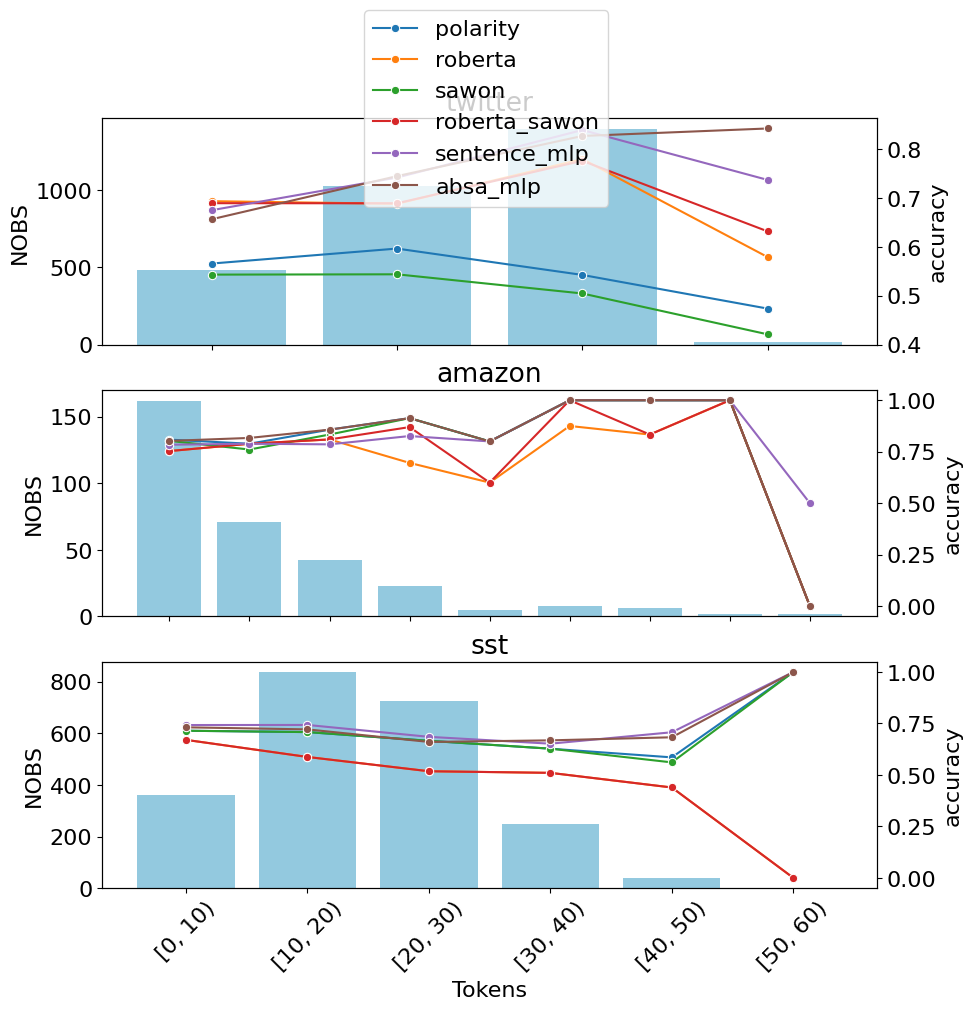

In [91]:
plot_metrics_per_token_count_bins(dataset_dict, preds_dict, "accuracy")

/Users/pawel.marcinkowski/.pyenv/versions/venv-spacy/lib/python3.10/site-packages/pandas/core/construction.py:632: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  data = np.array(data, copy=copy)
/Users/pawel.marcinkowski/.pyenv/versions/venv-spacy/lib/python3.10/site-packages/pandas/core/construction.py:632: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  data = np.array(data, copy=copy)
/Users/pawel.marcinkowski/.pyenv/versions/venv-spacy/lib/python3.10/site-packages/pandas/c

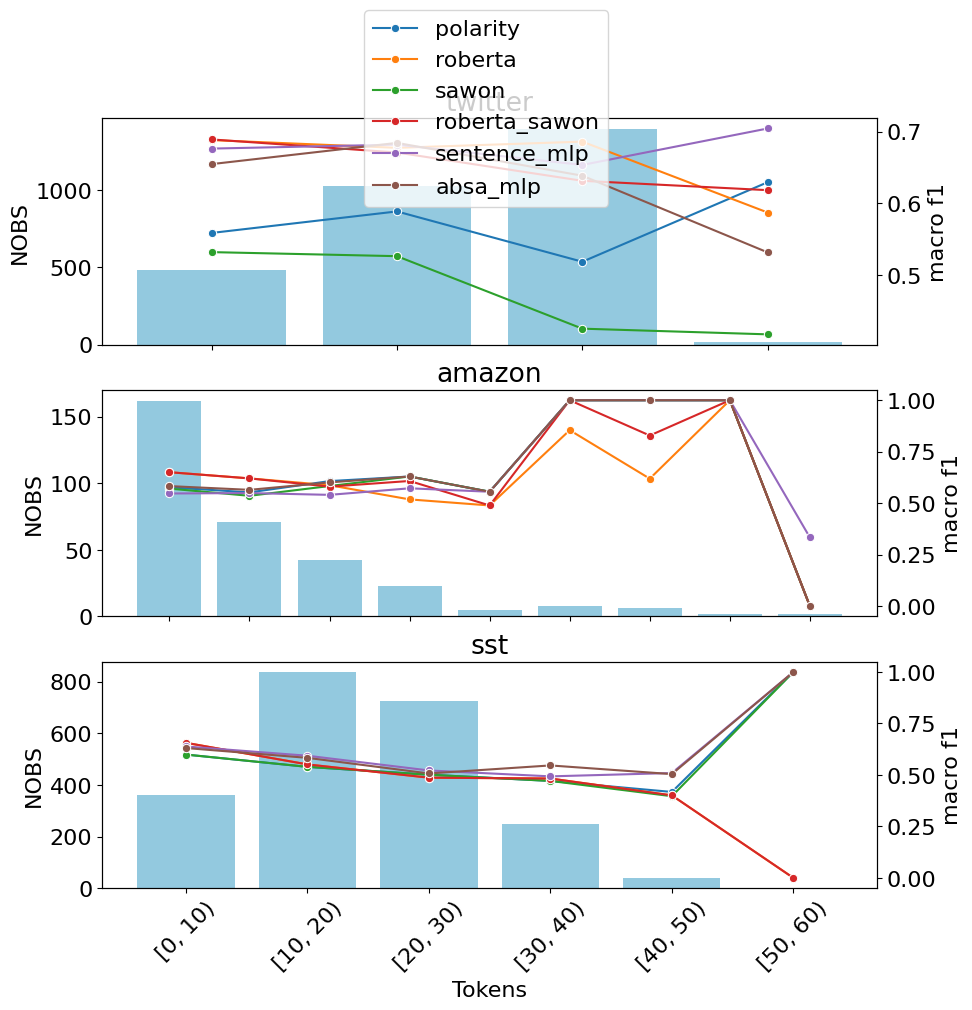

In [92]:
plot_metrics_per_token_count_bins(dataset_dict, preds_dict, "macro f1")

/Users/pawel.marcinkowski/.pyenv/versions/venv-spacy/lib/python3.10/site-packages/pandas/core/construction.py:632: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  data = np.array(data, copy=copy)
/Users/pawel.marcinkowski/.pyenv/versions/venv-spacy/lib/python3.10/site-packages/pandas/core/construction.py:632: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  data = np.array(data, copy=copy)
/Users/pawel.marcinkowski/.pyenv/versions/venv-spacy/lib/python3.10/site-packages/pandas/c

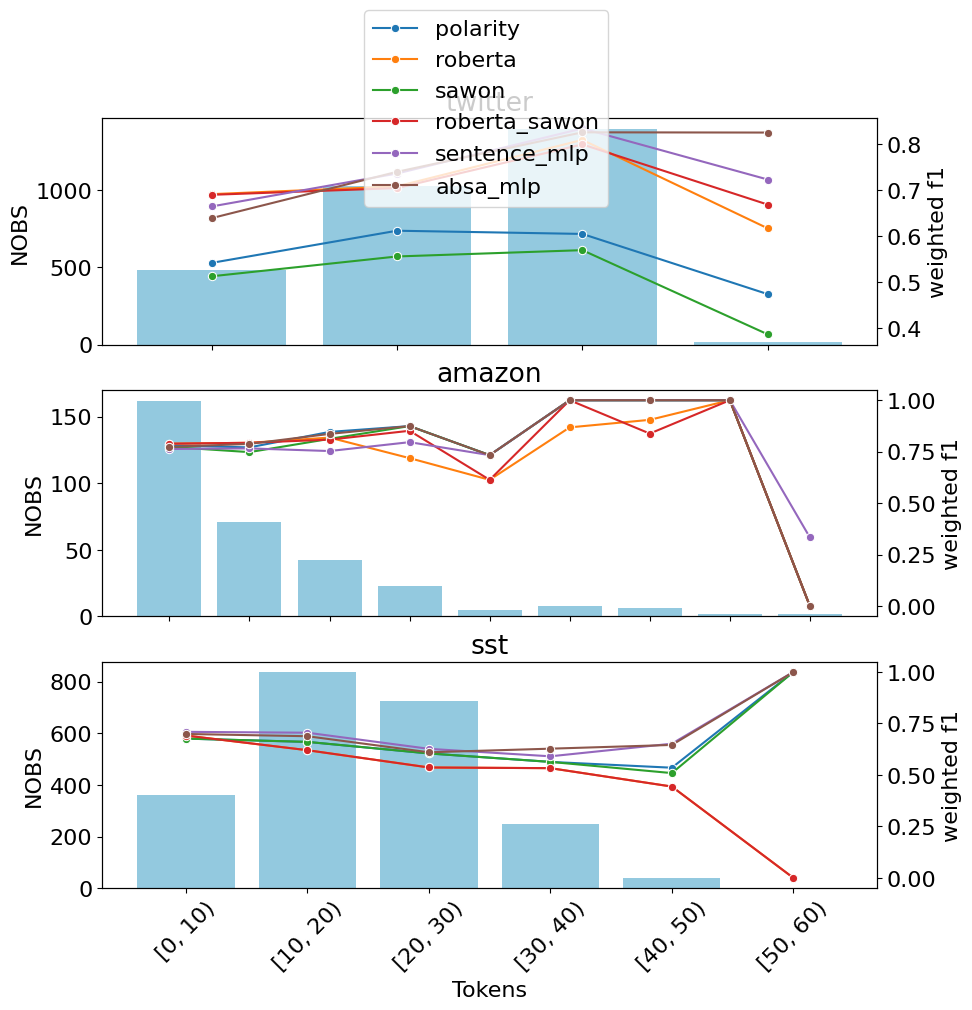

In [93]:
plot_metrics_per_token_count_bins(dataset_dict, preds_dict, "weighted f1")